In [18]:
import sys
import matplotlib.pyplot as plt
import numpy as np

# Work around for relative imports
if ".." not in sys.path:
    sys.path.insert(0,"..")

from Scripts.htm_model_v4 import network, G, cell, segment, synapse, sparse_encoder_decoder
import Scripts

plt.rcParams["figure.figsize"] = [15, 7]

# Investigating Dipak Ghosals code: Reconnection and Higher Order Behavior

[Turns out that Numenta starts off with 0 segments per cell.](https://discourse.numenta.org/t/htm-learning-algorithm-temporal-memory/8884/14?u=djpasseyjr)

In [2]:
class G:
    # WORKING_DIRECTORY = "/Users/dghosal/Documents/HTM-Work"
    # WORKING_DIRECTORY = os.getcwd()

    # Network paramaters
    number_of_columns = 100
    cells_per_column = 10
    
    
    list_of_column_ids = list(range(1,number_of_columns+1))
    list_of_ids_in_a_column = list(range(1,cells_per_column+1))
    
    # cell_id = (colum_id, cell_in_column_id)
    
    
    # Cell parameters
    number_of_segments_min = 64
    number_of_segments_max = 64
    fixed_number_of_segments = 10
    
    
    # segment parameters
    max_num_synapses = 30
    min_num_synapses = 20
    fixed_num_synapses = 25
    
    theta = 5
    
     
    # synapse parameter
    
    max_p_value = 1
    min_p_value = 0

    alpha = 0.3 
    
    
    # synaptic strength update parameters 
    
    small_decrement = -0.05
    very_small_decrement = -0.01
    large_increment = 0.36
    
    
    # encoding parameters  
    encoding_length = 10  # number of columns activated for every input. 
    encoding_range = number_of_columns # 
    
    
    # This file will contain the encodings
    encodings_filename = "encodings_file.txt"
    
    
    
    # epoch length
    
    epoch_length = 12
    
    # training file
    # pre_training_filename = "tkamb_training.txt"
    #training_filename = "tkamb_training.txt"
    #training_filename_long = "tkamb_training_long.txt"
    #training_filename = "tkamb.txt"
    
    #training_filename = "training_file-two-inputs.txt"

    # training_filename = "mapped_data_22093.txt"
    
    # testing file
    # testing_filename = "testing_file.txt"
    
    # output file
    # output_filename = "output_file_v4_sm00_22093.txt"
    
    # pickle file to store the network
    # pickle_filename = "my_network_v4_sm00.p"
    
    
# Monkey typing to avoid editing the file
Scripts.htm_model_v4.G = G

In [3]:
class TempMem(network):
                
    def train_network(self, sdr, input_sequence):
        epoch_number = 1

        for char in input_sequence:
            input_char = char.lower()
            # Encode character as a feed forward input
            self.feed_forward_input = sdr.sparse_encode(input_char)
            
            # compute_cell_actovity_state
            self.compute_cell_activity_state(self.feed_forward_input)
                        
            # Accuracy
            predicted_active_overlapp = set(self.list_of_cells_predicted).intersection(set(self.active_cells_current))
            list_of_columns_predicted = []
            for cell_predicted in self.list_of_cells_predicted:
                list_of_columns_predicted.append(cell_predicted[0])   
            self.prediction_accuracy.append(len(predicted_active_overlapp)/len(self.feed_forward_input))

            # update the synpatic strengths
            self.update_segment_and_synapse(self.feed_forward_input)

            # update_cell_predictive_state
            self.compute_cell_predictive_state(self.feed_forward_input)
            
class TempMemNoReconnect(TempMem):
            
    def update_segment_and_synapse(self, feed_forward_input):
        """We comment out synapse reconnection from this function.
        """
        
        
        # Consider the three cases here all with respect to the set of cell in the columns 
        # correspoinding to the feedforward input
        
        # Case 1: cell was in predictive state and got activated
        #         These cell ids are in self.active_cells_predicted = []
        
        # Consider each cell at a time
        #print("List of active cells predicted {0}".format(self.active_cells_predicted))
        for cell_id in self.active_cells_predicted:
            
            # get all the segments that caused the cell to be in the predictive state in the previous
            #  timestep


            # To do this consider the previous active list and find all the active segments 
            # for which the intersection with tildeD is greater than theta
            self.cell_objects[cell_id].determine_segment_id_causing_predictive_state(self.active_cells_previous)
            
            
            # Find the man
            
            for segment_id in self.cell_objects[cell_id].segment_ids_causing_predictive_state.keys():
                
                # For each segment we update the synaptic strengths as follows 
                # self.cell_objects[cell_id].cell_segments[segment_id].print_segment_synapse_connection_strenght()
                # We decrement the p_value of all the synapses in dotdij
                self.cell_objects[cell_id].cell_segments[segment_id].update_all_synapses_in_dotdij(G.small_decrement)
                
                # next we find the overlapp of a(t-1) with dotdij and increment the  corresponding
                # synapses by a large value
                self.cell_objects[cell_id].cell_segments[segment_id].update_all_synapses_with_active_presynaptic_cell(self.active_cells_previous, G.large_increment)
                
        
        # Case 2: No cell in these winning columns were in a predictive state
        # Hence all the cell in the columns became active
        
        # This is a set of column_ids 

        # for each column in the set 
        #print(self.active_cell_notpredicted_column_ids)
        #print("List of cells not-predicted column ids {0}".format(self.active_cell_notpredicted_column_ids))
        for i in self.active_cell_notpredicted_column_ids:
            max_cell_id = ()
            max_segment_id = -1
            max_segment_overlapp = set()
            for j in G.list_of_ids_in_a_column:
                cell_id = (i,j)
                # get a list of segment id and their overlapps with the previous active cells
                self.cell_objects[cell_id].determine_segment_id_strengths(self.active_cells_previous)
                for segment_id in self.cell_objects[cell_id].segment_id_strengths.keys():
                    if len(self.cell_objects[cell_id].segment_id_strengths[segment_id]) > len(max_segment_overlapp):
                        max_cell_id = cell_id
                        max_segment_id = segment_id
                        max_segment_overlapp = self.cell_objects[cell_id].segment_id_strengths[segment_id]
                
            # At this point we have the following case
                        
            # Case 1: We have found a segment that has some strength max_strength > 0 
            #         In thism case we find the number of additional synapses and update
            #         their strengths
            
            #print("Max cell_id: {0}, max_segment_id: {1}, len of overlap: {2}".format(max_cell_id, max_segment_id, len(max_segment_overlapp)))
            
#             if (len(max_segment_overlapp) > 0):
#                  num_synapses_to_reconnect = G.theta - len(max_segment_overlapp) + 1
#                  self.cell_objects[max_cell_id].cell_segments[max_segment_id].update_and_reconnect_synapses(num_synapses_to_reconnect, max_segment_overlapp, self.active_cells_previous)
            
            # # Case 2: max_strength > 0 
            # #     In this case we consider a random segment and consider the lowest G.theta + synapases 
            # #     and reassign remote id's and update strengths
#             elif (len(max_segment_overlapp) == 0):
#                 j = np.random.randint(1, G.cells_per_column+1)
#                 max_cell_id = (i,j)
#                 self.cell_objects[max_cell_id]
#                 max_segment_id = self.cell_objects[max_cell_id].num_segments + 1
                
#                 num_synapses_to_reconnect = G.theta + 1
#                 self.cell_objects[max_cell_id].cell_segments[max_segment_id].update_and_reconnect_synapses(num_synapses_to_reconnect, max_segment_overlapp, self.active_cells_previous)  
        
        # Case 3: cells that did not  become active but had active dendritic segments 
        #         For these segments we decay the synaptic strenghts
        for cell_id in self.cells_not_activated:
            
            # We find the strengths of the segments 
            self.cell_objects[cell_id].determine_segment_id_strengths(self.active_cells_previous)
            for segment_id in self.cell_objects[cell_id].segment_strengths.keys(): 
                if self.cell_objects[cell_id].segment_strengths[segment_id] > G.theta:
                    # For the active segments decrement p_value and dotdij
                    for synapse_id in self.cell_objects[cell_id].segment_strengths[segment_id].segment_synapses.keys():
                        self.cell_objects[cell_id].segment_strengths[segment_id].update_synapse(synapse_id, G.very_small_decrement, ())


        

### Normal algorithm

In [20]:
enc = sparse_encoder_decoder(32)
on_off = "oa"
for char in on_off:
    enc.sparse_encode(char)
    
tm = TempMem(G.number_of_columns, G.cells_per_column)
tm.initialize_network()

In [21]:
predictions = []

for i in range(100):
    tm.train_network(enc, on_off)
    predictions.append(tm.list_of_cells_predicted)

Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6
Error reconnecting synapses: len of remote  cell ids 0 < number of synapses to reconnect 6

In [22]:
def vectorize_predictions(active_cell_idxs, ncols, nrows):
    A = np.zeros((ncols, nrows))
    for i, j in active_cell_idxs:
        A[i-1, j-1] = 1.0
    return np.ravel(A)

def raster_matrix(predictions, ncols, nrows):
    R = np.vstack([vectorize_predictions(p, ncols, nrows) for p in predictions])
    return R.T

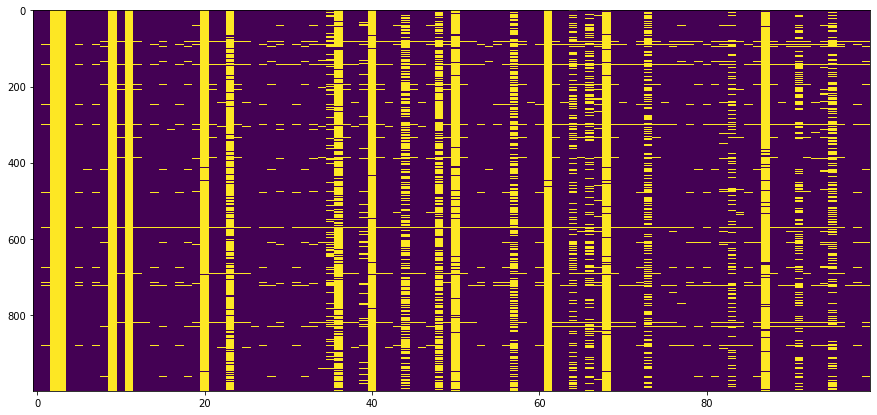

In [23]:
R = raster_matrix(predictions, G.number_of_columns, G.cells_per_column)
plt.imshow(R, aspect="auto", interpolation="none")

In [8]:
tm.prediction_accuracy

[0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.9375,
 0.09375,
 1.0,
 1.0,
 0.96875,
 0.0,
 1.0,
 1.0,
 0.96875,
 0.9375,
 0.03125,
 1.0,
 1.0,
 1.0,
 0.9375,
 0.90625,
 0.5,
 1.0,
 0.65625,
 1.0,
 0.53125,
 1.0,
 0.6875,
 1.0,
 0.0625,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0625,
 1.0,
 1.0,
 0.96875,
 0.9375,
 0.96875,
 0.0,
 1.0,
 1.0,
 0.96875,
 0.96875,
 0.34375,
 1.0,
 1.0,
 0.78125,
 1.0,
 0.21875,
 1.0,
 1.0,
 0.96875,
 1.0,
 0.21875,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96875,
 0.125,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96875,
 0.90625,
 0.28125,
 1.0,
 0.9375,
 0.96875,
 1.0,
 0.875,
 0.96875,
 0.09375,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96875,
 0.90625,
 0.96875,
 0.09375,
 1.0,
 1.0,
 1.0,
 1.0,
 0.96875,
 0.90625,
 0.96875,
 0.9375,
 0.15625,
 1.0,
 1.0,
 0.96875,
 1.0,
 0.875,
 1.0,
 0.09375,
 1.0,
 1.0,
 1.0,
 1.0,
 0.6875,
 1.0,
 0.625,
 1.0,
 0.15625,
 1.0,
 1.0,
 0.96875,
 1.0,
 0.90625,
 0.96875,
 0.9375,
 0.28125,
 1.0,
 1.0,
 0.96875,
 1.0,

### No synapse rewiring

In [9]:
enc = sparse_encoder_decoder(32)
tm = TempMemNoReconnect(G.number_of_columns, G.cells_per_column)
tm.initialize_network()

In [13]:
predictions = []

for i in range(100):
    tm.train_network(enc, on_off)
    predictions.append(tm.list_of_cells_predicted)

KeyboardInterrupt: 

In [14]:
len(predictions)

24

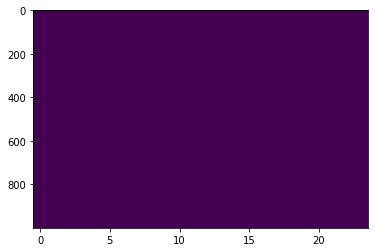

In [15]:
R = raster_matrix(predictions, G.number_of_columns, G.cells_per_column)
plt.imshow(R, aspect="auto", interpolation="none")

In [17]:
tm.prediction_accuracy

506